In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Charger les données MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

#Afficher la stucture des donnees du dataset
print("Dimensions des données d'entraînement:", train_images.shape)
print("Dimensions des étiquettes d'entraînement:", train_labels.shape)
print("Dimensions des données de test:", test_images.shape)
print("Dimensions des étiquettes de test:", test_labels.shape)

# Diviser les données en sous-ensembles pour chaque utilisateur
num_users = 10
train_images_per_user = len(train_images) // num_users
train_images_by_user = [train_images[i:i+train_images_per_user] for i in range(0, len(train_images), train_images_per_user)]
#le resultat est un tableau contenat dix entrees (une pour chaque uitilisateur) et chaque entree est un tableau de 28 vecteurs ayant 28 valeurs chacun
train_labels_by_user = [train_labels[i:i+train_images_per_user] for i in range(0, len(train_labels), train_images_per_user)]


Dimensions des données d'entraînement: (60000, 28, 28)
Dimensions des étiquettes d'entraînement: (60000,)
Dimensions des données de test: (10000, 28, 28)
Dimensions des étiquettes de test: (10000,)


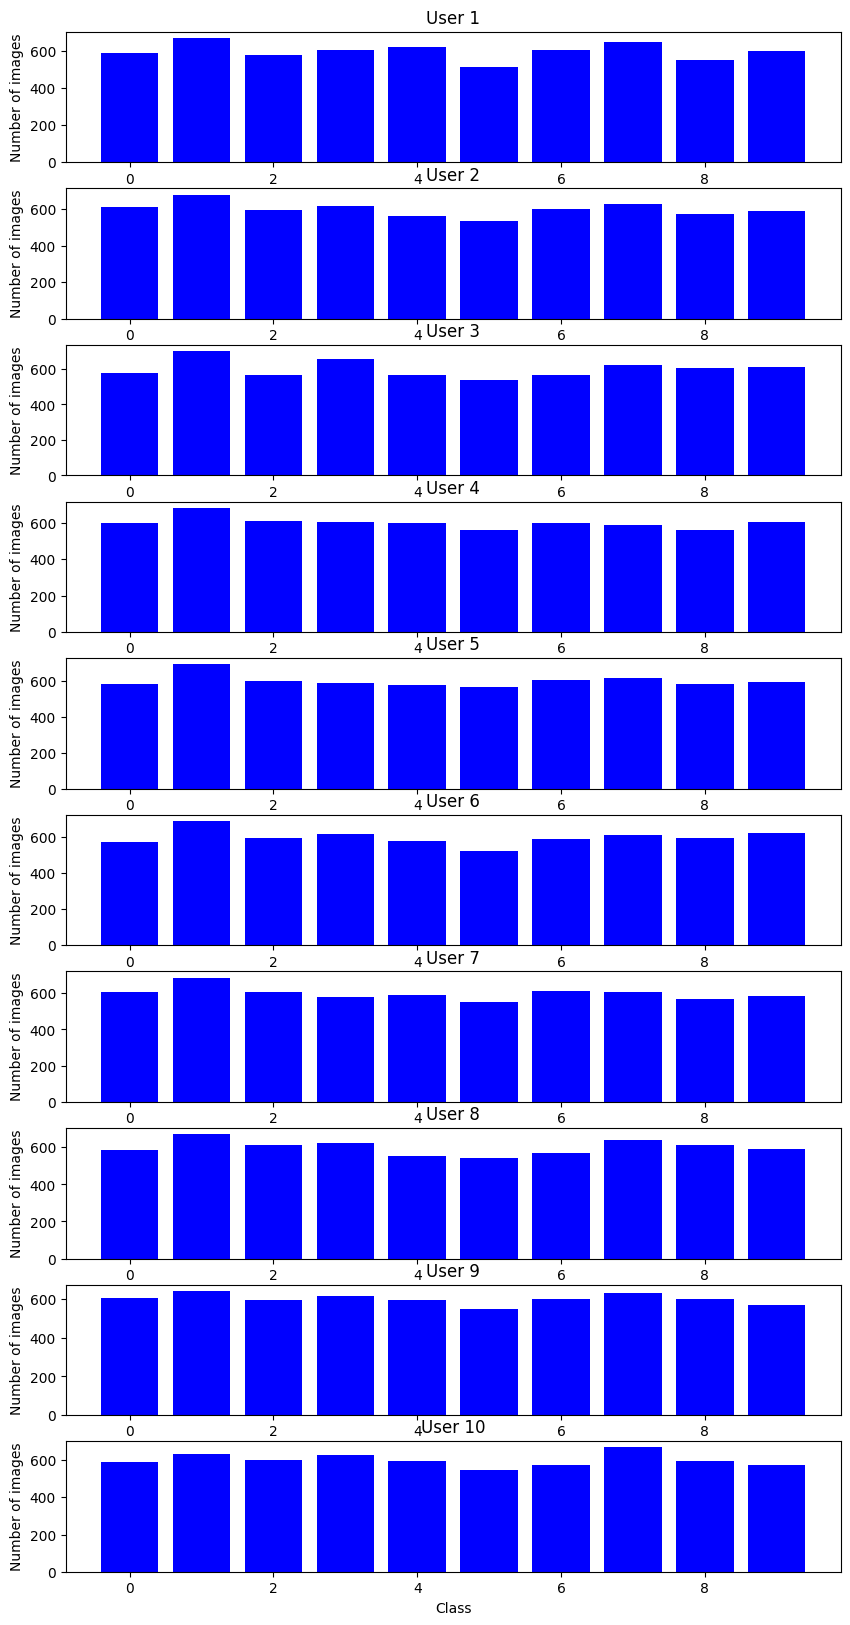

In [40]:
#Cette partie du code permet d'afficher la repartition des donnees selon les classes pour chaque utilisateur
user_data = [
    (train_images_by_user[0], train_labels_by_user[0]),
    (train_images_by_user[1], train_labels_by_user[1]),
    (train_images_by_user[2], train_labels_by_user[2]),
    (train_images_by_user[3], train_labels_by_user[3]),
    (train_images_by_user[4], train_labels_by_user[4]),
    (train_images_by_user[5], train_labels_by_user[5]),
    (train_images_by_user[6], train_labels_by_user[6]),
    (train_images_by_user[7], train_labels_by_user[7]),
    (train_images_by_user[8], train_labels_by_user[8]),
    (train_images_by_user[9], train_labels_by_user[9]),
]
# Initialiser le dictionnaire des comptages
class_counts = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

# Compter les images de chaque classe pour chaque utilisateur
for user_images, user_labels in user_data:
    for i in range(len(user_images)):
        image_class = user_labels[i]
        class_counts[image_class].append(1)


# Créer un histogramme pour chaque utilisateur
fig, axs = plt.subplots(nrows=len(user_data), ncols=1, figsize=(10, 20))
for i, (user_images, user_labels) in enumerate(user_data):
    counts = [len([x for x in user_labels if x == class_index]) for class_index in range(10)]
    axs[i].bar(range(10), counts, color='blue')
    axs[i].set_xlabel('Class')
    axs[i].set_ylabel('Number of images')
    axs[i].set_title('User {}'.format(i+1))
plt.show()

In [3]:
#Cette fonction permet de creer les modeles locaux pour chaque subset (utilisateur)
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model


In [4]:
def federated_averaging(model, rounds, num_users, train_images_by_user, train_labels_by_user, test_images, test_labels):
  for round in range(rounds):
    # Sélectionner les utilisateurs pour cette ronde
    selected_users = np.random.choice(num_users, size=num_users, replace=False)

    # Initialiser les listes pour stocker les modèles locaux et les poids de chaque utilisateur
    local_models = []
    user_weights = []

    # Entraîner des modèles locaux pour chaque utilisateur
    for user in selected_users:
      local_model = create_model()
      local_model.set_weights(model.get_weights())

      local_model.fit(train_images_by_user[user], train_labels_by_user[user], epochs=1, verbose=0)

      local_models.append(local_model)
      user_weights.append(len(train_images_by_user[user]))

    # Calculer la moyenne pondérée des poids de chaque utilisateur
    weights = [weight / sum(user_weights) for weight in user_weights]

    # Fusionner les modèles locaux en un modèle global
    global_weights = []
    for i in range(len(model.get_weights())):
      global_weight = np.zeros_like(model.get_weights()[i])
      for j in range(len(local_models)):
        global_weight += weights[j] * local_models[j].get_weights()[i]
      global_weights.append(global_weight)
    model.set_weights(global_weights)

    # Évaluer le modèle global sur les données de test
    _, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print('Round {}: Test accuracy = {}'.format(round+1, accuracy))


In [5]:
# Créer un modèle initial
initial_model = create_model()

# Effectuer l'apprentissage fédéré
federated_averaging(initial_model, rounds=10, num_users=10, train_images_by_user=train_images_by_user, train_labels_by_user=train_labels_by_user, test_images=test_images, test_labels=test_labels)


Round 1: Test accuracy = 0.88919997215271
Round 2: Test accuracy = 0.9041000008583069
Round 3: Test accuracy = 0.8690000176429749
Round 4: Test accuracy = 0.8636000156402588
Round 5: Test accuracy = 0.8777999877929688
Round 6: Test accuracy = 0.8934000134468079
Round 7: Test accuracy = 0.9052000045776367
Round 8: Test accuracy = 0.9114999771118164
Round 9: Test accuracy = 0.9229000210762024
Round 10: Test accuracy = 0.9247999787330627


1/1 [==============================] - 0s 24ms/step
La prédiction est : 7


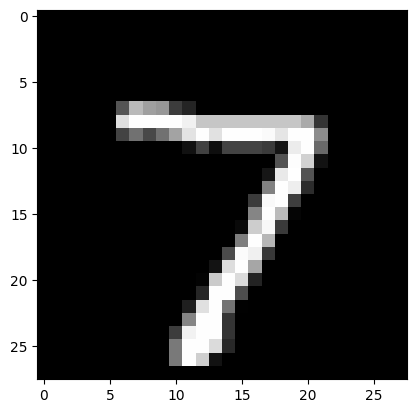

In [38]:
# Charger une image de test
test_image = test_images[0]

# Effectuer une prédiction sur l'image
predictions = initial_model.predict(np.expand_dims(test_image, axis=0))

# Afficher la prédiction
print('La prédiction est : {}'.format(np.argmax(predictions)))

# Afficher l'image
plt.imshow(test_image, cmap='gray')
plt.show()
